<a href="https://colab.research.google.com/github/PDNow-Research/PDNow/blob/main/HandPD/NeuralNets/CNN_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import sys
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import RMSprop
from PIL import Image
import PIL
print(Image.__file__)
import cv2
import glob
import pandas as pd
import imageio

/usr/local/lib/python3.7/dist-packages/PIL/Image.py


## Load Data + Preprocessing

In [109]:
def extract_images(path, c): # path of data, class of data
  filename_arr = []
  X_arr = []

  fixed_height = 550

  for file in glob.glob(path):
    filename_arr.append(file) # filenames, not going to use them for now. Might need them later.

    # not going to resize first, may do later if needed
    image = Image.open(file)
    height_percent = (fixed_height / float(image.size[1]))
    width_size = int((float(image.size[0]) * float(height_percent)))
    image = image.resize((width_size, fixed_height), PIL.Image.NEAREST)
    image.save(file)

    x = cv2.imread(file)
    # print(x.shape)
    # We'll remove the color channels later, first we want to do some extraction
    # x = x[:,:,0] # removing all color channels to make data smaller and possible to use
    X_arr.append(x)

  y_arr = [c] * len(X_arr)

  return X_arr, y_arr

## **Testing**

In [434]:
X_meah, y_meah = extract_images("/content/drive/MyDrive/Data/Images/Old_Meander/MeanderControl/*.*",0)
X_meap, y_meap = extract_images("/content/drive/MyDrive/Data/Images/Old_Meander/MeanderPatients/*.*",1)

X_meander = X_meah + X_meap
y_meander = y_meah + y_meap

### Exam Trace

In [537]:
len(X_meander)
index = 300

In [538]:
test_im = X_meander[index].copy()

In [439]:
test_im.shape

(550, 583, 3)

In [440]:
test_im[:,:,0]

array([[237, 240, 242, ..., 250, 250, 250],
       [239, 241, 242, ..., 251, 251, 251],
       [241, 241, 241, ..., 252, 252, 252],
       ...,
       [243, 240, 243, ..., 254, 254, 254],
       [239, 236, 239, ..., 254, 254, 254],
       [240, 236, 238, ..., 251, 251, 251]], dtype=uint8)

In [441]:
# test_im = np.divide(test_im, 255)

1. Original

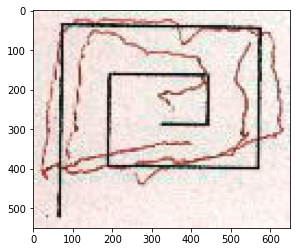

In [539]:
im = Image.fromarray(test_im)
plt.imshow(im)
plt.show()

2. Blur

In [540]:
blur_im = test_im.copy()

ksize = (5, 5)
blur_im = cv2.blur(blur_im, ksize) 

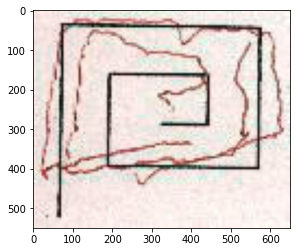

In [541]:
im = Image.fromarray(blur_im)
plt.imshow(im)
plt.show()

3. Threshold to Extract Image Trace

In [542]:
thresh_im = blur_im.copy()

for i in range (thresh_im.shape[0]):
  for j in range (thresh_im.shape[1]):
      if (thresh_im[i, j, 0] < 90 and thresh_im[i, j, 1] < 90 and thresh_im[i, j, 2] < 90):
        thresh_im[i, j, 0] = 0;
        thresh_im[i, j, 1] = 0;
        thresh_im[i, j, 2] = 0;
      else:
        thresh_im[i, j, 0] = 255;
        thresh_im[i, j, 1] = 255;
        thresh_im[i, j, 2] = 255;

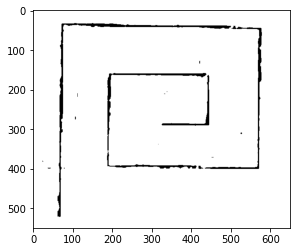

In [543]:
im = Image.fromarray(thresh_im)
plt.imshow(im)
plt.show()

4. Erode/Dilate

In [544]:
erode_im = thresh_im.copy()

In [545]:
# types possible: MORPH_RECT;// MORPH_RECT; //MORPH_ELLIPSE; // MORPH_RECT; // MORPH_CROSS
erosion_shape = 1
erosion_size = 4
element = cv2.getStructuringElement(erosion_shape, (2 * erosion_size + 1, 2 * erosion_size + 1),
                                       (erosion_size, erosion_size))

In [546]:
erode_im  = cv2.erode(erode_im, element) 

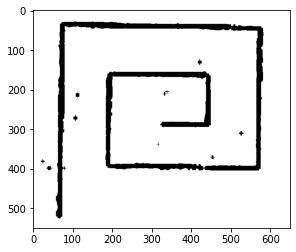

In [547]:
im = Image.fromarray(erode_im)
plt.imshow(im)
plt.show()

### Handwriting Trace

1. Original

In [548]:
httest_im = X_meander[index].copy()

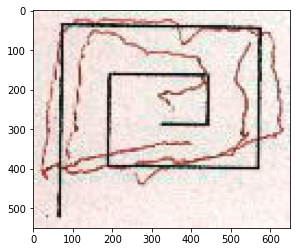

In [549]:
im = Image.fromarray(httest_im)
plt.imshow(im)
plt.show()

2. Blur

In [550]:
htblur_im = httest_im.copy()

ksize = (5, 5)
blur_im = cv2.blur(blur_im, ksize) 

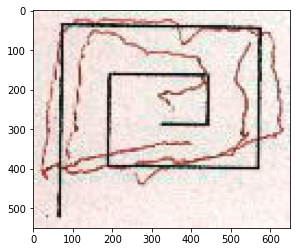

In [551]:
im = Image.fromarray(htblur_im)
plt.imshow(im)
plt.show()

3. Mean/Median Filtering

In [552]:
# median filtering
htmed_im = htblur_im.copy()

htmed_im = cv2.medianBlur(htmed_im, 5)

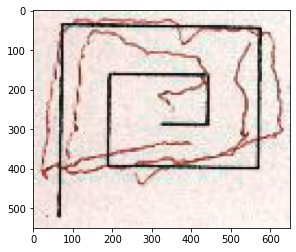

In [553]:
im = Image.fromarray(htmed_im)
plt.imshow(im)
plt.show()

3. Idea 1: Difference Threshold with Trace

In [554]:
htdiff_im = htmed_im.copy()

In [555]:
# previous thresholding strategy
for i in range (htdiff_im.shape[0]):
  for j in range (htdiff_im.shape[1]):
      if (htdiff_im[i, j, 0] < 200 and htdiff_im[i, j, 1] < 200 and htdiff_im[i, j, 2] < 200):
        htdiff_im[i, j, 0] = 0;
        htdiff_im[i, j, 1] = 0;
        htdiff_im[i, j, 2] = 0;
      else:
        htdiff_im[i, j, 0] = 255;
        htdiff_im[i, j, 1] = 255;
        htdiff_im[i, j, 2] = 255;

In [407]:
# new thresholding strategy
for i in range (htdiff_im.shape[0]):
  for j in range (htdiff_im.shape[1]):
      if ((htdiff_im[i, j, 0] - htdiff_im[i, j, 1]) < 20
          and (htdiff_im[i, j, 0] - htdiff_im[i, j, 2]) < 20 
          and (httest_im[i, j, 1] - httest_im[i, j, 2]) < 20):
        htdiff_im[i, j, 0] = 255;
        htdiff_im[i, j, 1] = 255;
        htdiff_im[i, j, 2] = 255;
        # else, no change

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in ubyte_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in ubyte_scalars
  


In [564]:
htdiff_im = erode_im - htdiff_im

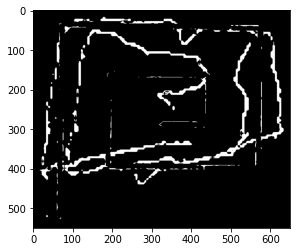

In [565]:
im = Image.fromarray(htdiff_im.astype('uint8'))
plt.imshow(im)
plt.show()

In [576]:
htblur2_im = htdiff_im.copy()
size = (500, 500)
htblur2_im = cv2.medianBlur(htblur2_im, 5) 

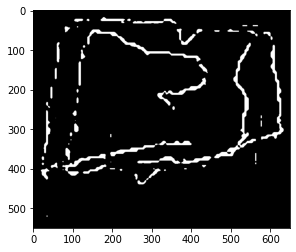

In [577]:
im = Image.fromarray(htblur2_im.astype('uint8'))
plt.imshow(im)
plt.show()

In [581]:
htdilate_im = htblur2_im.copy()

In [582]:
dilation_shape = 0
dilation_size = 2
element = cv2.getStructuringElement(dilation_shape, (2 * dilation_size + 1, 2 * dilation_size + 1),
                                       (dilation_size, dilation_size))

htdilate_im  = cv2.dilate(htdilate_im, element) 

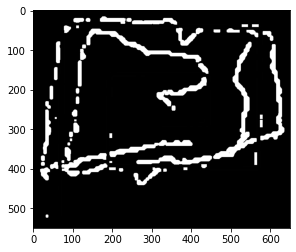

In [583]:
im = Image.fromarray(htdilate_im)
plt.imshow(im)
plt.show()

## **Padding**

In [6]:
def pad_images(array):
  arr = array.copy()
  largestX = 0
  largestY = 0

  def pad_condition(pad, largest, index):
    if (2 * pad != (largest - arr[i].shape[index])):
      pad1 = pad + 1
      pad2 = pad
    else:
      pad1, pad2 = pad, pad
    return pad1, pad2

  for i in arr:
    X = i.shape[0]
    Y = i.shape[1]
    if (X > largestX):
      largestX = X
    if (Y > largestY):
      largestY = Y

  for i in range(len(arr)):
    X_pad = int((largestX - arr[i].shape[0]) /2) # pad equally in both directions, must be int
    Y_pad = int((largestY - arr[i].shape[1]) /2)
    
    # but int floors, so we might get something of a slightly wrong shape (by 1), so...
    X_pad1, X_pad2 = pad_condition(X_pad, largestX, 0)
    Y_pad1, Y_pad2 = pad_condition(Y_pad, largestY, 1)

    arr[i] = np.pad(arr[i], ((X_pad1, X_pad2), (Y_pad1, Y_pad2)), 'constant', constant_values=(0)) # each image in arr in 2D
    
  maxSize = largestX * largestY
  
  return arr, maxSize

In [7]:
def normalize_images(arr, num):
  arr = np.array(arr)/num
  return arr

In [ ]:
# Old Hand PD image extraction
X_meah, y_meah = extract_images("/content/drive/MyDrive/Data/Images/Old_Meander/MeanderControl/*.*",0)
X_meap, y_meap = extract_images("/content/drive/MyDrive/Data/Images/Old_Meander/MeanderPatients/*.*",1)

X_meander = X_meah + X_meap
y_meander = y_meah + y_meap

X_spih, y_spih = extract_images("/content/drive/MyDrive/Data/Images/Old_Spiral/SpiralControl/*.*",0)
X_spip, y_spip = extract_images("/content/drive/MyDrive/Data/Images/Old_Spiral/SpiralPatients/*.*",1)

X_spiral = X_spih + X_spip
y_spiral = y_spih + y_spip

In [ ]:
# New Hand PD image extraction, ignoring all PD patient data (what we did to fix class imbalance in SVM)

X_new_meah, y_new_meah = extract_images("/content/drive/MyDrive/Data/Images/New_Meander/HealthyMeander/HealthyMeander/*.*",0)
# X_new_meap, y_new_meap = extract_images("/content/drive/MyDrive/Data/Images/New_Meander/PatientMeander/PatientMeander/*.*",1)

X_new_meander = X_new_meah # + X_new_meap
y_new_meander = y_new_meah # + y_new_meap

X_new_spih, y_new_spih = extract_images("/content/drive/MyDrive/Data/Images/New_Spiral/HealthySpiral/HealthySpiral/*.*",0)
# X_new_spip, y_new_spip = extract_images("/content/drive/MyDrive/Data/Images/New_Spiral/PatientSpiral/PatientSpiral/*.*",1)

X_new_spiral = X_new_spih # + X_new_spip
y_new_spiral = y_new_spih # + y_new_spip

In [ ]:
X_all = X_spiral + X_new_spiral + X_meander + X_new_meander
X_all, maxSize = pad_images(X_all)
X_all = normalize_images(X_all, 255)

In [ ]:
y_all = np.array(y_spiral + y_new_spiral + y_meander + y_new_meander)

In [ ]:
y_all_series = pd.Series(y_all)
y_all_series.value_counts()

1    592
0    424
dtype: int64

In [ ]:
len(y_all)

1016

In [ ]:
maxSize

13700

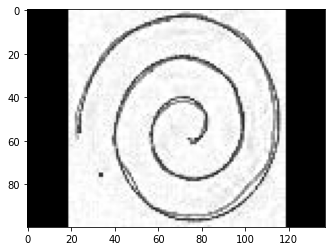

In [ ]:
im = Image.fromarray((X_all[0] *255))
plt.imshow(im)
plt.show()

### Train-Test-Split

Consider random state and possibility for different train test validation sets.

In [ ]:
y_label = y_all.copy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, random_state = 0, test_size = 0.15, stratify = y_label)

In [ ]:
len(y_train), len(y_test)

(863, 153)

In [ ]:
# consider setting test_size to larger 

train_labels = y_train.copy()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 0, test_size = 0.1, stratify = train_labels)

In [ ]:
len(y_train), len(y_val)

(776, 87)

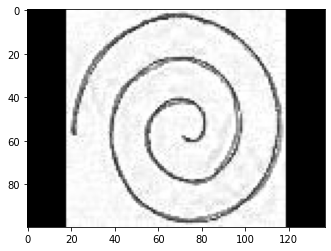

In [ ]:
im = Image.fromarray((X_train[0] *255))
plt.imshow(im)
plt.show()

### Saving to Directories

In [ ]:
# sequence level storage, no patient level rn

def save_to_directories(X, y, path):
  
  # convert numpy array to image
  for i in range(len(X)):
    label = y[i]
    # X[i] = X[i].astype('uint8') converts to 8 bit, bad for storage

    # find image's label, control or patient
    if label == 1:
      # save image to correct directory
      path_pd = path + "/Patient/image_{}.jpg".format(i+1)
      imageio.imwrite(path_pd, X[i])

    elif label == 0:
      path_control = path + "/Control/image_{}.jpg".format(i+1)
      imageio.imwrite(path_control, X[i])

In [ ]:
save_to_directories(X_train, y_train, "/content/drive/MyDrive/Data/Images/Split_Data/Train") # we'll ignore the warning for now
save_to_directories(X_val, y_val, "/content/drive/MyDrive/Data/Images/Split_Data/Validation") # we'll ignore the warning for now
save_to_directories(X_test, y_test, "/content/drive/MyDrive/Data/Images/Split_Data/Test") # we'll ignore the warning for now

## Loading Data into Tensorflow

In [ ]:
WIDTH = 137
HEIGHT = 100

In [ ]:
train_dir = "/content/drive/MyDrive/Data/Images/Split_Data/Train"
val_dir = "/content/drive/MyDrive/Data/Images/Split_Data/Validation"
test_dir = "/content/drive/MyDrive/Data/Images/Split_Data/Test"

In [ ]:
train_data = ImageDataGenerator()
val_data = ImageDataGenerator()
test_data = ImageDataGenerator()

In [ ]:
train_generator = train_data.flow_from_directory(
    train_dir, 
    target_size = (WIDTH, HEIGHT), 
    batch_size = 4, 
    class_mode = 'binary' 
)

val_generator = val_data.flow_from_directory(
    val_dir, 
    target_size = (WIDTH, HEIGHT), 
    batch_size = 4, 
    class_mode = 'binary' 
)

test_generator = test_data.flow_from_directory(
    test_dir, 
    target_size = (WIDTH, HEIGHT), 
    batch_size = 4, 
    class_mode = 'binary' 
)

Found 776 images belonging to 2 classes.
Found 87 images belonging to 2 classes.
Found 153 images belonging to 2 classes.


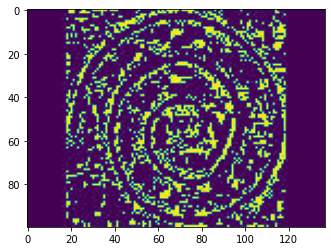

In [ ]:
im = Image.open("/content/drive/MyDrive/Data/Images/Split_Data/Train/Control/image_1.jpg")
plt.imshow(im)
plt.show()

In [ ]:
model = tf.keras.models.Sequential([
    #conv net part
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(100, 137, 1)), 
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    #dnn part
    tf.keras.layers.Flatten(),
   
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),

    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 98, 135, 16)       160       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 49, 67, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 47, 65, 32)        4640      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 23, 32, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 21, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 10, 15, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 13, 64)        

In [ ]:
class callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
    #creating a callback function that activates if the accuracy is greater than 60%
        if (logs.get('accuracy') > 0.975):
          print("Stopping Training")
          self.model.stop_training = True
            
callbacks = callback()

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate = 0.0001),
              metrics=['accuracy'])

In [ ]:
#training model after loading data in using an image generator
history = model.fit (
    #training part
    train_generator,
    steps_per_epoch = 4, 
    epochs = 15,
    
    #validation part
    validation_data = val_generator,
    validation_steps = 4,
    callbacks = [callbacks],
)

Epoch 1/15


UnimplementedError: ignored